In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import scipy.optimize
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()  # Nice plot aesthetic

In [3]:
np.random.seed(123)

# Generate choice data

In [4]:
def generate_data(w, u, seed=123, max_x=1, n=100, tau=3.333):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = w(p0) * u(x0)
    seu1 = w(p1) * u(x1)

    diff_eu = seu1 - seu0

    p_choice_1 = expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)

    return data

In [5]:
def u_data(x): return x**0.5
def w_data(p): return p
data = generate_data(w=w_data, u=u_data, n=1000)

# Likelihood whole model given M, $\theta_M$

In [6]:
def objective(param, data, u_m, w_m):
    
    alpha = np.exp(param[0])
    tau = np.exp(param[1])
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    seu0 = p0 * u_m(x0, alpha)
    seu1 = p1 * u_m(x1, alpha)

    diff_eu = seu1 - seu0

    p_choice_1 = expit(tau*diff_eu) # p choose 1
    p_choice_y = p_choice_1**y * (1-p_choice_1)**(1-y)
    return - np.log(p_choice_y).sum()

In [7]:
def u_m(x, alpha): return x**alpha
def w_m(p): return p

opt = scipy.optimize.minimize(objective, x0=(0.0, 0.0), args=(data, u_m, w_m))
print(np.exp(opt.x))

[0.53506421 3.28496402]


# Model discrepancy

In [12]:
def build_model(u_m, w_m, data, seed=12345, max_n=100):
    
    np.random.seed(seed)
    
    opt = scipy.optimize.minimize(objective, x0=(0.0, 0.0), args=(data, u_m, w_m))
    opt_param = np.exp(opt.x)
    alpha, tau = opt_param
    print(f"Estimates: alpha={alpha:.3f}, tau={tau:.3f}")
    
    if len(data) > max_n:
        data = data.sample(n=max_n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    y = data.choices.values 
    
    x = np.hstack((x0, x1))
    p = np.hstack((p0, p1))
    x_order = np.argsort(x)
    x_sorted = x[x_order]
    p_sorted = p[x_order]
    undo_sorted = np.argsort(x_order)
    
    with pm.Model() as model:

        ρ = pm.InverseGamma('ρ', 2, 2)
        η = pm.HalfCauchy('η', 5)

        X = x_sorted.reshape(-1, 1)
        uX = u_m(X, alpha)

        M = pm.gp.mean.Constant(uX.flatten())
        K = tt.dot(uX, uX.T) * η**2 * pm.gp.cov.ExpQuad(1, ρ)

        gp = pm.gp.Latent(mean_func=M, cov_func=K)
        f = gp.prior("f", X=X)

        est_eu =  w_m(p_sorted) * f    
        est_eu_unsorted = est_eu[undo_sorted]
        n = len(y)
        diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])

        est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit(tau*diff_eu_hat))
        choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)
        
    return model, gp, x_sorted, opt_param

# Measure discrepancy

In [13]:
def u_m(x, alpha): return x**alpha
def w_m(p): return p

In [14]:
model, gp, x_sorted, opt_param = build_model(u_m=u_m, w_m=w_m, data=data)

with model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, 
                  target_accept=0.90)

Estimates: alpha=0.535, tau=3.285


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, η, ρ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 155 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f"])

[]

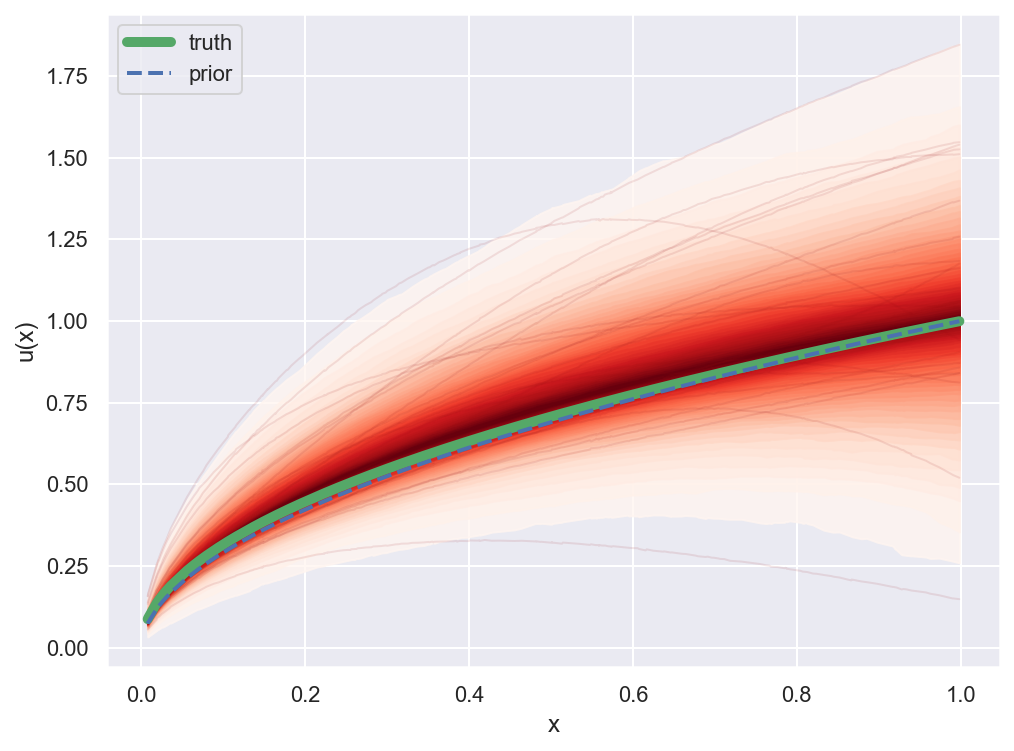

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted.reshape(-1, 1))
ax.plot(x_sorted, u_data(x_sorted), lw=5, color='C2', label="truth")
ax.plot(x_sorted, u_m(x_sorted, opt_param[0]), lw=2, ls='--', color='C0', label="prior")
ax.set_xlabel("x")
ax.set_ylabel("u(x)")
ax.legend()
plt.plot()

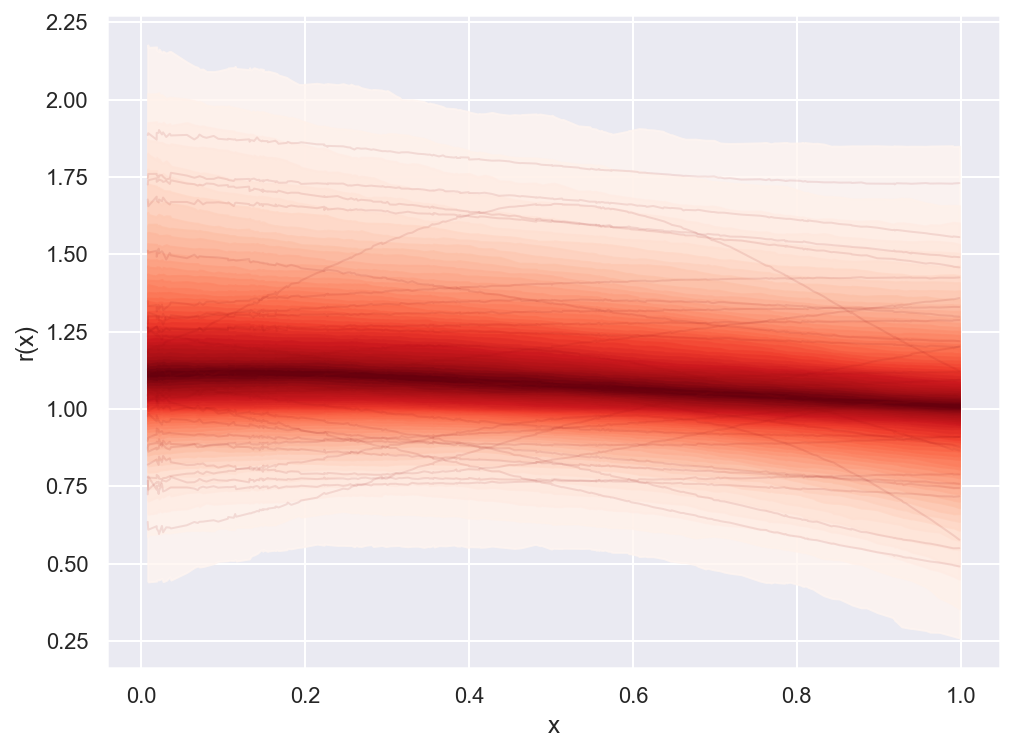

In [21]:
r = pred_samples["f"]/u_m(x_sorted, opt_param[0])

fig, ax = plt.subplots(figsize=(8, 6))
pm.gp.util.plot_gp_dist(ax, r, x_sorted.reshape(-1, 1))
ax.set_xlabel("x")
ax.set_ylabel("r(x)");

In [22]:
np.mean(r)

1.1282296079802618

In [23]:
np.mean(r**2)

1.361136999901593